In [1]:
%matplotlib inline
import sys, os, time
from collections import defaultdict

import numpy as np

import rasterio

import matplotlib
import matplotlib.pyplot as plt

from sklearn.cluster import MiniBatchKMeans

In [2]:
def humansize(nbytes):
    suffixes = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']
    i = 0
    while nbytes >= 1024 and i < len(suffixes)-1:
        nbytes /= 1024.
        i += 1
    f = ('%.2f' % nbytes).rstrip('0').rstrip('.')
    return '%s %s' % (f, suffixes[i])

## List downloaded tiles

In [3]:
DOWNLOAD_DIR = "/media/data/landsat_2000/"

fns = [
    os.path.join(DOWNLOAD_DIR, fn)
    for fn in os.listdir(DOWNLOAD_DIR)
    if fn.endswith(".tif")
]

## Load and display one tile

In [28]:
%%time

f = rasterio.open(fns[3], "r")
tile = f.read()
# the GeoTIFFs downloaded from GEE are loaded in a channel first format
tile = np.rollaxis(tile, 0, 3) # convert to channel last format
f.close()

CPU times: user 9.23 s, sys: 5.13 s, total: 14.4 s
Wall time: 48.1 s


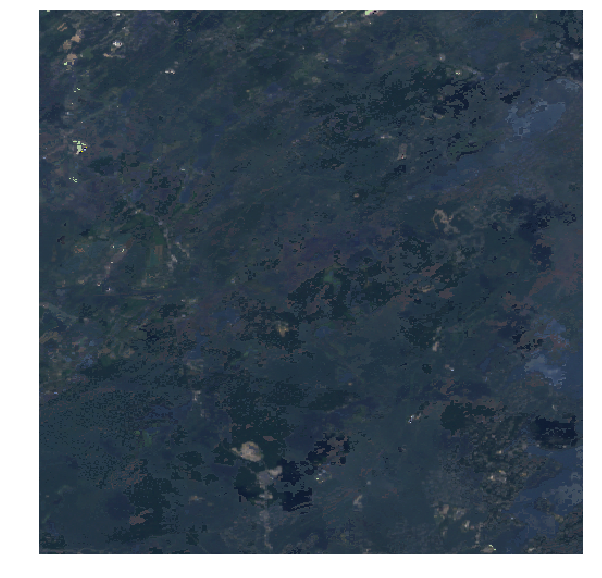

In [30]:
image = tile[:1000,:1000, [2,1,0]]
normalization = 100.0

plt.figure(figsize=(10,10))
plt.imshow(image / normalization)
plt.axis("off")
plt.figure("")
plt.show()
plt.close()

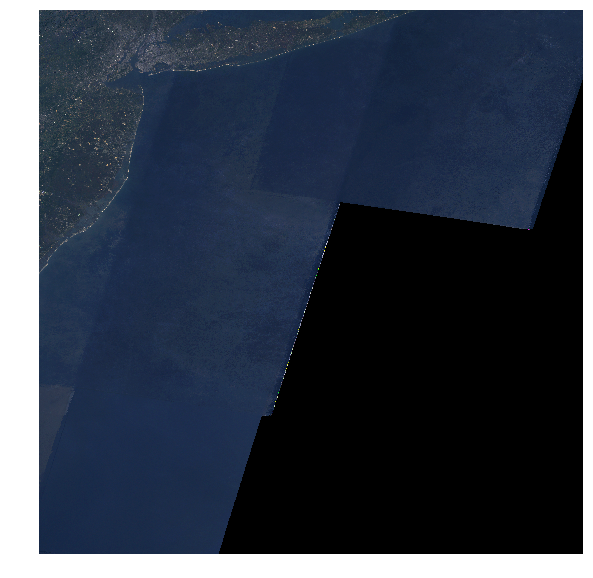

In [31]:
image = tile[::4,::4, [2,1,0]]
normalization = 100.0

plt.figure(figsize=(10,10))
plt.imshow(image / normalization)
plt.axis("off")
plt.show()
plt.close()

## Sample random patches from all tiles

In [7]:
num_tiles = len(fns)
print("Number of tiles to sample from: %d" % (num_tiles))

Number of tiles to sample from: 79


In [8]:
num_patches_per_tile = 1000
patch_width = 107
patch_height = 107
patch_num_channels = tile.shape[2]

num_patches = num_tiles * num_patches_per_tile

In [9]:
percent_sampled = float(num_patches_per_tile) / ((tile.shape[0] / patch_height) * (tile.shape[1] / patch_width))
print("Percentage of tile sampled: %f%%" % (percent_sampled * 100))

Percentage of tile sampled: 1.197304%


In [10]:
%%time

patches = np.zeros((num_patches, patch_height, patch_width, patch_num_channels), dtype=np.uint8)
patch_coordinates = np.zeros((num_patches, 2), np.uint32)
print("Patch array has size: %s" % (humansize(patches.nbytes)))

tile_sizes = []

tic = float(time.time())
patch_index = 0
for i, fn in enumerate(fns[:num_tiles]):
    print("%d/%d\t%0.4f seconds" % (i, len(fns), time.time() - tic))
    tic = float(time.time())

    
    
    f = rasterio.open(fn, "r")
    data = f.read()
    data = np.rollaxis(data, 0, 3)
    tile_sizes.append(data.shape)
    f.close()
    
    
    for j in range(num_patches_per_tile):
        
        k = np.random.randint(0, data.shape[0] - patch_height)
        l = np.random.randint(0, data.shape[1] - patch_width)
        
        patches[patch_index] = data[k:k+patch_height, l:l+patch_width, :]
        patch_coordinates[patch_index] = [k, l]
        
        patch_index += 1

Patch array has size: 5.9 GB
0/79	0.0000 seconds
1/79	45.9918 seconds
2/79	8.5536 seconds
3/79	47.3478 seconds
4/79	48.2819 seconds
5/79	47.3787 seconds
6/79	46.6740 seconds
7/79	46.4821 seconds
8/79	47.2894 seconds
9/79	46.5759 seconds
10/79	47.6781 seconds
11/79	47.3670 seconds
12/79	30.5744 seconds
13/79	46.5310 seconds
14/79	40.4362 seconds
15/79	46.2788 seconds
16/79	48.7651 seconds
17/79	47.4072 seconds
18/79	47.0788 seconds
19/79	46.0544 seconds
20/79	46.8528 seconds
21/79	46.7880 seconds
22/79	46.6901 seconds
23/79	47.5336 seconds
24/79	40.0187 seconds
25/79	46.6757 seconds
26/79	46.7125 seconds
27/79	46.4422 seconds
28/79	46.8529 seconds
29/79	47.1207 seconds
30/79	46.4380 seconds
31/79	50.1110 seconds
32/79	48.7105 seconds
33/79	46.7232 seconds
34/79	46.8449 seconds
35/79	47.4562 seconds
36/79	46.4113 seconds
37/79	47.3298 seconds
38/79	47.0334 seconds
39/79	49.9686 seconds
40/79	48.7302 seconds
41/79	47.6984 seconds
42/79	48.5971 seconds
43/79	47.0159 seconds
44/79	46.3469 s

## Calculate patch features

In [11]:
def get_color_histogram_from_patches(patches):
    features = np.zeros((patches.shape[0], 256*patches.shape[-1]),dtype=np.uint32)
    
    for i in range(patches.shape[-1]):
        bins = np.apply_along_axis(lambda x: np.bincount(x, minlength=256), axis=1, arr=patches[:,:,i])
        features[:, i*256:(i+1)*256] += bins.astype(np.uint32)
    
    return features

In [12]:
patches = patches.reshape(num_patches, patch_height * patch_width, patch_num_channels)

In [13]:
features = get_color_histogram_from_patches(patches)

## "Train" KMeans model

In [48]:
kmeans = MiniBatchKMeans(
    n_clusters=4,
    init="k-means++",
    max_iter=100,
    batch_size=1000,
    verbose=1,
    compute_labels=True,
    random_state=None,
    tol=0.0,
    max_no_improvement=10,
    init_size=None,
    n_init=3,
    reassignment_ratio=0.01
)

In [49]:
kmeans.fit(features)

Init 1/3 with method: k-means++
Inertia for init 1/3: 267293767769.021729
Init 2/3 with method: k-means++
Inertia for init 2/3: 247719979177.452606
Init 3/3 with method: k-means++
Inertia for init 3/3: 271366932769.361481
Minibatch iteration 1/7900: mean batch inertia: 82194186.332173, ewa inertia: 82194186.332173 
Minibatch iteration 2/7900: mean batch inertia: 85464474.079951, ewa inertia: 82276977.379065 
Minibatch iteration 3/7900: mean batch inertia: 82999126.921239, ewa inertia: 82295259.414537 
Minibatch iteration 4/7900: mean batch inertia: 84142619.120407, ewa inertia: 82342027.422686 
Minibatch iteration 5/7900: mean batch inertia: 81002652.527600, ewa inertia: 82308119.626706 
Minibatch iteration 6/7900: mean batch inertia: 85158285.563384, ewa inertia: 82380274.813012 
Minibatch iteration 7/7900: mean batch inertia: 87641090.288179, ewa inertia: 82513458.329048 
Minibatch iteration 8/7900: mean batch inertia: 80737495.377475, ewa inertia: 82468497.810787 
Minibatch iteratio

MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=4,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=1)

In [50]:
labels = kmeans.predict(features)

Computing label assignment and total inertia


In [51]:
print(np.unique(labels, return_counts=True))

(array([0, 1, 2, 3], dtype=int32), array([ 8551, 10757, 35735, 23957]))


## Apply model

In [52]:
%%time

num_patches_in_tile = (tile.shape[0] / patch_height) * (tile.shape[1] / patch_width)
patches = np.zeros((
    num_patches_in_tile,
    patch_height, patch_width,
    patch_num_channels
), dtype=np.uint8)

patch_index = 0
for i in range(0, tile.shape[0], patch_height):
    for j in range(0, tile.shape[1], patch_width):
        patches[i] = tile[i:i+patch_height, j:j+patch_width, :]
        patch_index += 1

CPU times: user 6.32 s, sys: 12.3 ms, total: 6.33 s
Wall time: 6.33 s


In [53]:
patches = patches.reshape(num_patches_in_tile, patch_height * patch_width, patch_num_channels)

In [54]:
tile_features = get_color_histogram_from_patches(patches)

In [55]:
cluster_labels = kmeans.predict(tile_features)

Computing label assignment and total inertia


In [56]:
cluster_labels = cluster_labels.reshape((tile.shape[0] / patch_height), (tile.shape[1] / patch_width))

In [58]:
print(np.unique(cluster_labels, return_counts=True))

(array([0, 1, 2], dtype=int32), array([   37, 83483,     1]))


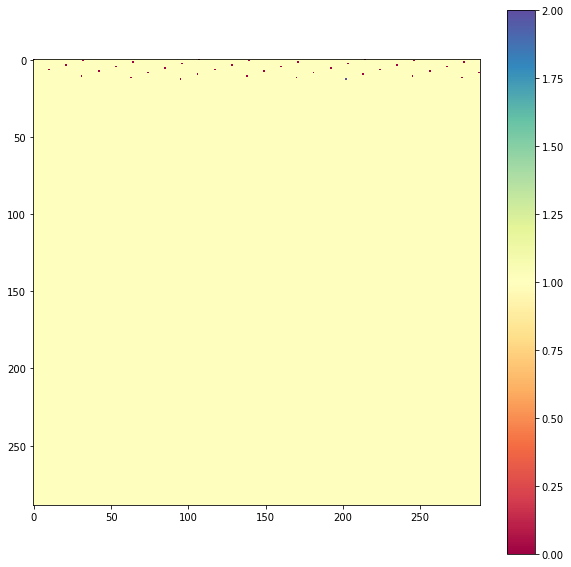

In [57]:
plt.figure(figsize=(10,10))
plt.imshow(cluster_labels, cmap="Spectral")
plt.colorbar()
plt.show()
plt.close()

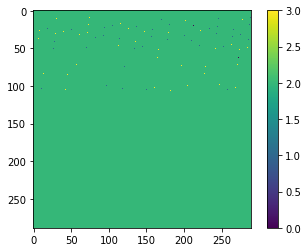

In [49]:
cmap = matplotlib.cm.get_cmap('Spectral')
norm = matplotlib.colors.Normalize(vmin=0, vmax=num_clusters-1)

grid = np.zeros((grid_shape[0], grid_shape[1], 4), dtype=float)
r = 3

fig, ax = plt.subplots(1,1,figsize=(21,14))

for i in range(len(cluster_coords)):
    color = cmap(norm(i))
    print i, color
    
    grid[-100:, i*100:(i+1)*100, :] = color
    
    for j in range(cluster_coords[i].shape[0]):
        coord_y = cluster_coords[i][j,0]
        coord_x = cluster_coords[i][j,1]
        
        grid[coord_y-r:coord_y+r+1, coord_x-r:coord_x+r+1] = color
    #plt.scatter(cluster_coords[i][:,1], cluster_coords[i][:,0], color=cmap(norm(i)))
plt.imshow(grid)

SpatialLib.turn_off_axis_info(ax)

plt.tight_layout()

plt.show()
plt.close()